# XGBoost implementation

The following implementation aims to classify each one of the days as an opportunity to sell or buy stocks. The selected stocks for this implementation are:

- Google
- Microsoft
- Visa

This will be accomplished by the calculation of indexes that work as momentum indicatiors and using the data in a XGBoost classifier. Using this data we'll be able to predict and estimate how buying stocks of these companies will perform.

pip install xgboost

## Libraries

In [93]:
#data
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path  

#metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#model
import xgboost as xgb

## Data preprocessing

The initial hypothesis is that we need to take a look at the fields related to the stock prices and trading sales. In order to analyze if the prices seem to be relevant in the trading volume. The fisrt step is to import our data from a csv file.

In [94]:
df_msft = pd.read_csv('../database/ticker_MSFT.csv')
df_goog = pd.read_csv('../database/ticker_GOOG.csv')
df_v = pd.read_csv('../database/ticker_V.csv')

In [95]:
dflist = [df_msft, df_goog, df_v]

Set the 'date' field as an index and making sure it is a datetime and not a string for plotting purposes

In [96]:
def setIndex(df):
    
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    
    return df

After geting the data from our dataframes we'll proceed to drop the columns that will not be necessary for the model. Since the calculations of the multiple indexes that we'll be working with only need the closing prices of the stocks on each day and in some cases the transaction volumes, we'll drop the columns referring to the daly:

- Opening price
- Daily High
- Daily Low

In [97]:
for i in range(len(dflist)):
    dflist[i] = setIndex( dflist[i])
    dflist[i] =  dflist[i].drop(columns=['Open','High','Low'])
    

In [98]:
dflist

[                 Close   Adj Close    Volume Symbol
 Date                                               
 2021-12-06  326.190002  320.321655  30032600   MSFT
 2021-12-07  334.920013  328.894592  31021900   MSFT
 2021-12-08  334.970001  328.943665  24761000   MSFT
 2021-12-09  333.100006  327.107300  22214200   MSFT
 2021-12-10  342.540009  336.377502  38095700   MSFT
 ...                ...         ...       ...    ...
 2023-11-29  378.850006  378.850006  28963400   MSFT
 2023-11-30  378.910004  378.910004  30554400   MSFT
 2023-12-01  374.510010  374.510010  33020400   MSFT
 2023-12-04  369.140015  369.140015  32037800   MSFT
 2023-12-05  371.372009  371.372009   5084218   MSFT
 
 [503 rows x 4 columns],
                  Close   Adj Close    Volume Symbol
 Date                                               
 2021-12-06  143.796494  143.796494  22198000   GOOG
 2021-12-07  148.036499  148.036499  23258000   GOOG
 2021-12-08  148.720505  148.720505  18964000   GOOG
 2021-12-09  148.10

#### Plot Variables

In [99]:
GROUPS = ['MSFT','GOOG','V']

def plotVariables(df,vars, title):
    i = 0
    for group in df:
        group[vars].plot(
            figsize=(10, 5),
            title=f"{title} - Stock: {GROUPS[i]}",
            subplots=True,
        )
        plt.show()
        i+=1

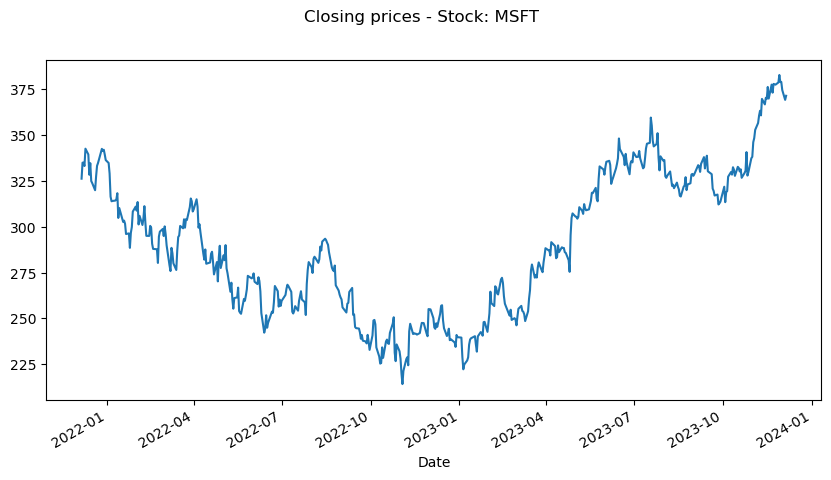

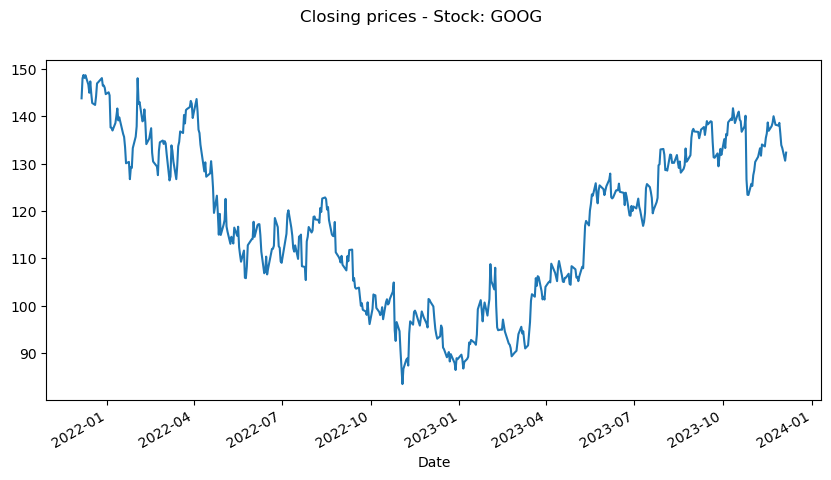

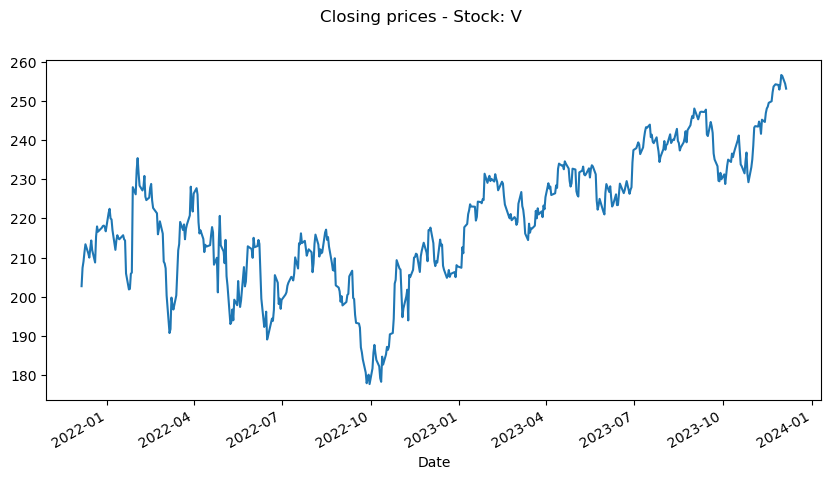

In [100]:
plotVariables(dflist,'Close', 'Closing prices')

## Feature creation

The next step is to create the necessary features for defining the stock's performance and forecast this same metric. Since we have an datetime index we can break this data into its components such as:

- Year
- Month
- Quarter
- Day

In order to get an easier view of the data and how did the stocks performed in different periods of time. 

Also for an accurrate prediction of whether to buy or sell stocks we'll do the calculations of multiple indexes such as the following:

- Relative Strength Index (RSI)
- Stochastic Oscillator
- Williams percentage range
- Moving Average convergence divergence
- Price rate of change
- On balance volume

These are momentum indicators that give buy and sell signals based on their results. We'll have a definition period of 14 days by default for the calculation of these indexes

In [101]:
period = 14

In [102]:
def addGainLoss(df):
    """Calculates gain or loss on the closing price of a stock"""
    df['Gain'] = df['Close'].diff().where(lambda x: x > 0, 0)
    df['Loss'] = abs(df['Close'].diff().where(lambda x: x < 0, 0))
    
    return df[['Gain','Loss']]

def RSI(df):
    """
    Momentum indication that states if the stock is overbought or oversold
    >70 overbought
    <30 oversold
    """
    
    avg_gain = df['Gain'].rolling(window=period).mean()
    avg_loss = df['Loss'].rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))

    df['RSI'] = rsi
    return df['RSI']

def stochasticOscillator(df):
    """
    Follows momentum of the closing price, momentum changes before the price.
    Measures level of the closing price relative to lo-high range in a time period.
    Ranges 0-100
    """
    low = df['Close'].rolling(window=period).min()
    high = df['Close'].rolling(window=period).max()

    osci = 100 * (df['Close']-low)/(high-low)
    df['OSCI'] = osci
    return df['OSCI']

def williamsRate(df):
    """ 
    Momentum indicatior, indicates level of a closing price related to
    the highest price in a time period (14 days). Ranges -100 to 0
    
    >-20 sell signal
    <-80 buy signal
    """
    low = df['Close'].rolling(window=period).min()
    high = df['Close'].rolling(window=period).max()
    
    williams = -100 * (high-df['Close'])/(high-low)
    df['Williams'] = williams
    return df['Williams']

def movingAverageConvergenceDivergence(df):
    """ 
    Momentum indicator comparing moving averages of prices. A 26 day exponential moving average(EMA) is substracted from a 12 day EMA.
    A 9 day EMA is considered a signal line to compare with the MACD
    
    MACD < EMA9 = sell
    MACD > EMA9 = buy
    """
    
    ema_26 = df['Close'].transform(lambda x: x.ewm(span = 26).mean())
    ema_12 = df['Close'].transform(lambda x: x.ewm(span = 12).mean())
    macd = ema_12 - ema_26
    
    ema_9_macd = macd.ewm(span = 9).mean()

    df['MACD'] = macd
    df['MACD_SIGNAL'] = ema_9_macd
    
    return df[['MACD','MACD_SIGNAL']]

def rateChange(df):
    """ 
    percentage change in price between the current price and the price over 
    the window that we consider to be the time period of observation.
    """
    df['PROC'] = (df['Close']-df['Close'].shift(period-1))/df['Close'].shift(period-1)
    return df['PROC']

def onBalanceVolume(df):
    """ 
    uses changes in volume to estimate change in prices. 
    Finds buying and selling trends using the cumulative volumne 
    when the prices go up and substracts volume if they go down.
    Comparing to the previous day
    
    Falling trend -> sell
    Rising trend -> buy
    
    both price and OBV in uptrend -> buy
    both price and OBV in downtrend -> sell
    
    price up, obv not -> sell
    price down, obv not -> buy

    """
    # Grab the volume and close column.
    volume = df['Volume']
    change = df['Close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    df['OBV'] = obv_values
    
    return df['OBV']

def addClassLabel(df):
    """ 
    Create target feature for the prediction.
    Based on the change in prices.
    """
    
    df['Class'] = np.sign(df['Close'].diff()).fillna(0)
    df['Class'] = df['Class'].replace(1, 2)
    df['Class'] = df['Class'].replace(0, 1)
    df['Class'] = df['Class'].replace(-1, 0)



    return df['Class']

In [103]:
def addFeatures(df):
    
    df[['Gain','Loss']] = addGainLoss(df)
    df['RSI'] = RSI(df)
    df['OSCI'] = stochasticOscillator(df)
    df['Williams'] = williamsRate(df)
    df['PROC'] = rateChange(df)
    df['OBV'] = onBalanceVolume(df)
    df[['MACD','MACD_SIGNAL']] = movingAverageConvergenceDivergence(df)
    df['Class'] = addClassLabel(df)
    
    return df

In [104]:
for i in range(len(dflist)):
    dflist[i] = addFeatures(dflist[i])    


In [105]:
dflist[i]

,Close,Adj Close,Volume,Symbol,Gain,Loss,RSI,OSCI,Williams,PROC,OBV,MACD,MACD_SIGNAL,Class
Date,,,,,,,,,,,,,,
2021-12-06,202.679993,199.573517,10722100,V,0.000000,0.00000,NaN,NaN,NaN,NaN,0,0.000000,0.000000,1.0
2021-12-07,207.369995,204.191650,11897200,V,4.690002,0.00000,NaN,NaN,NaN,NaN,11897200,0.105224,0.058458,2.0
2021-12-08,208.990005,205.786804,11749200,V,1.620010,0.00000,NaN,NaN,NaN,NaN,23646400,0.184313,0.110038,2.0
2021-12-09,211.389999,208.150009,10176800,V,2.399994,0.00000,NaN,NaN,NaN,NaN,33823200,0.302418,0.175207,2.0
2021-12-10,213.399994,210.129211,8882700,V,2.009995,0.00000,NaN,NaN,NaN,NaN,42705900,0.440210,0.254040,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,254.229996,254.229996,4955100,V,1.289993,0.00000,77.534656,99.447020,-0.552980,0.052102,114854800,4.244927,3.707839,2.0
2023-11-30,256.679993,256.679993,6874700,V,2.449997,0.00000,89.746286,100.000000,-0.000000,0.046605,121729500,4.403562,3.846983,2.0
2023-12-01,256.450012,256.450012,3939400,V,0.000000,0.22998,86.036126,98.085091,-1.914909,0.048147,117790100,4.459319,3.969450,0.0


## Create our model

We define de features that will be used in our model and split the datsets into training and testing sets.

In [106]:
FEATURES = ['RSI','OSCI','Williams','PROC','OBV','MACD']
TARGET = 'Class'

list_train = []
list_test = []

split_date = '2023-01-01'

for df in dflist:
    list_train.append(df[df.index < split_date])
    list_test.append(df[df.index >= split_date])


Training the model

In [107]:
def trainModel(df_train,index):
    X_train = df_train[FEATURES]
    y_train = df_train[TARGET]
    
    model = xgb.XGBRFClassifier()

    model.fit(
        X_train,
        y_train,
    )
    
    fi = pd.DataFrame(
        data = model.feature_importances_, 
        index=model.feature_names_in_,
        columns=['importance']
    )
    
    fi.sort_values('importance').plot(kind='barh')
    plt.title(label=f'Feature importance for stock: {GROUPS[index]}')
    plt.show()
    
    return model

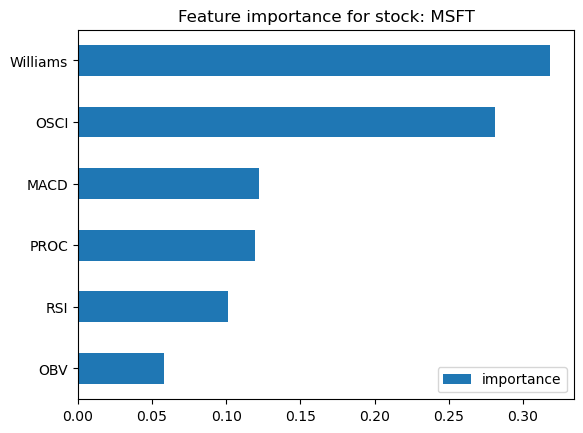

C:\Users\guzma\AppData\Local\Temp\ipykernel_15044\2507219555.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_test[i].loc[:, 'Direction_prediction'] = y_pred


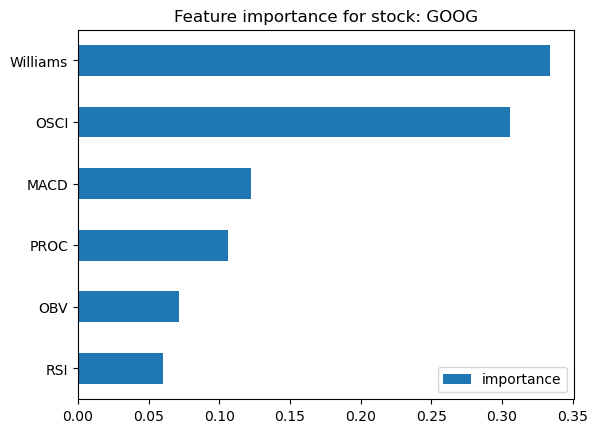

C:\Users\guzma\AppData\Local\Temp\ipykernel_15044\2507219555.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_test[i].loc[:, 'Direction_prediction'] = y_pred


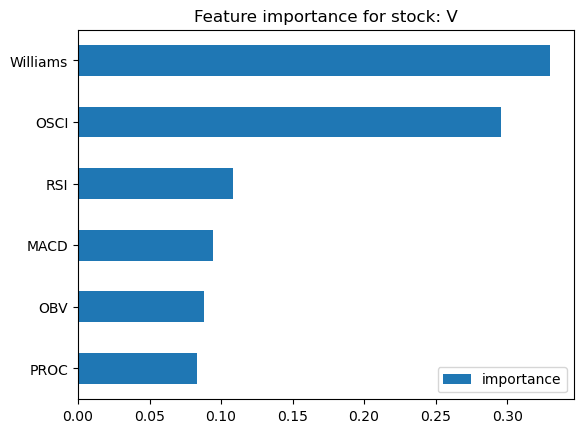

C:\Users\guzma\AppData\Local\Temp\ipykernel_15044\2507219555.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_test[i].loc[:, 'Direction_prediction'] = y_pred


In [108]:
for i in range(len(list_train)):
    model = trainModel(list_train[i],i)
    
    X_test = list_test[i][FEATURES]
    
    y_pred = model.predict(X_test)
    list_test[i].loc[:, 'Direction_prediction'] = y_pred

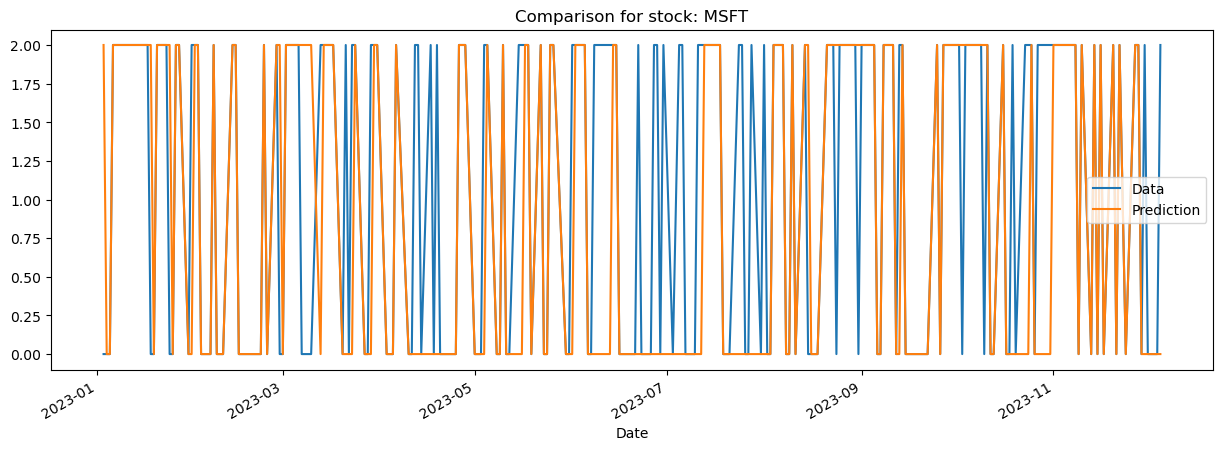

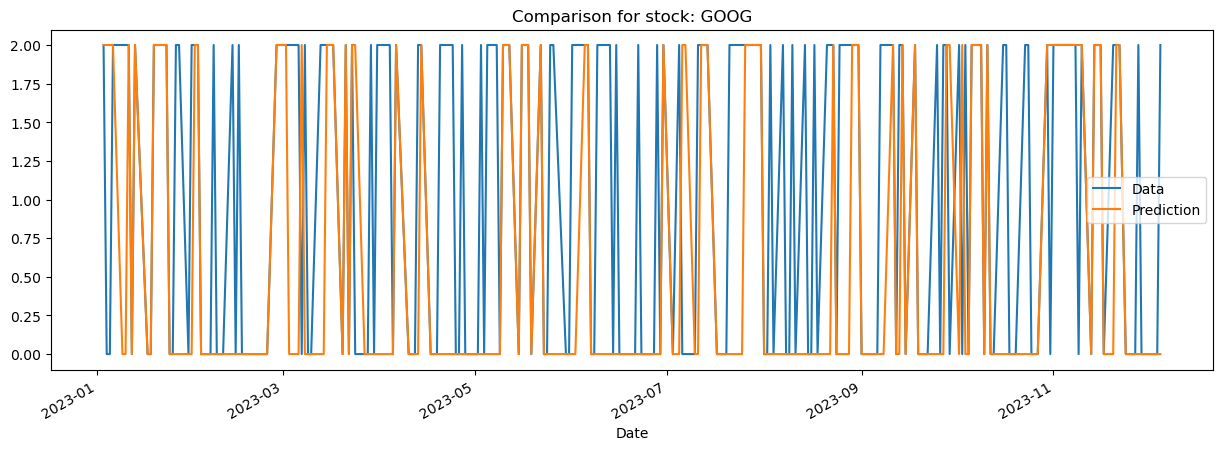

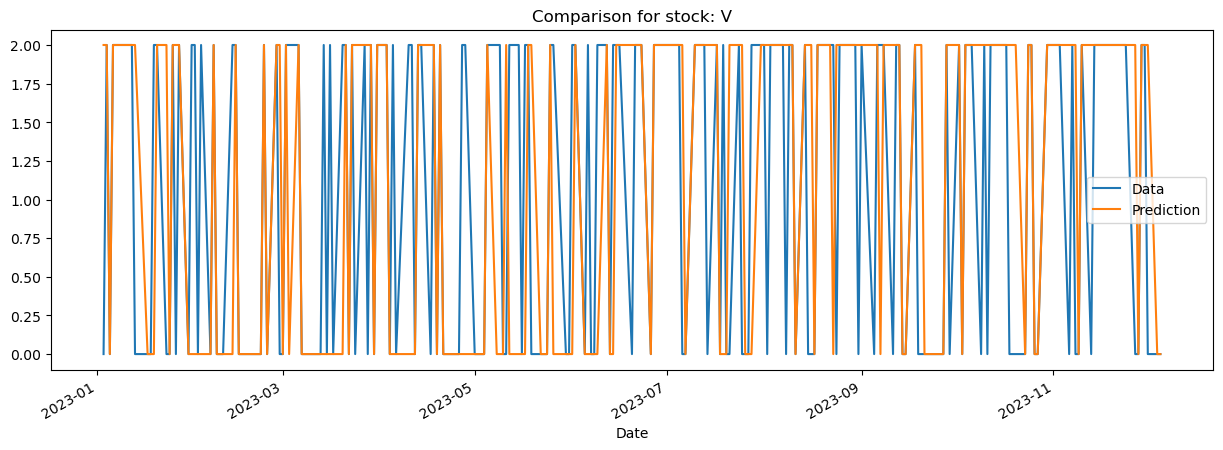

In [109]:
for i in range(len(list_test)):
    ax = list_test[i][['Class']].plot(figsize=(15,5))
    list_test[i]['Direction_prediction'].plot(ax=ax)
    plt.legend(['Data','Prediction'])
    plt.title(label=f'Comparison for stock: {GROUPS[i]}')
    plt.show()

MSFT
78.11158798283262


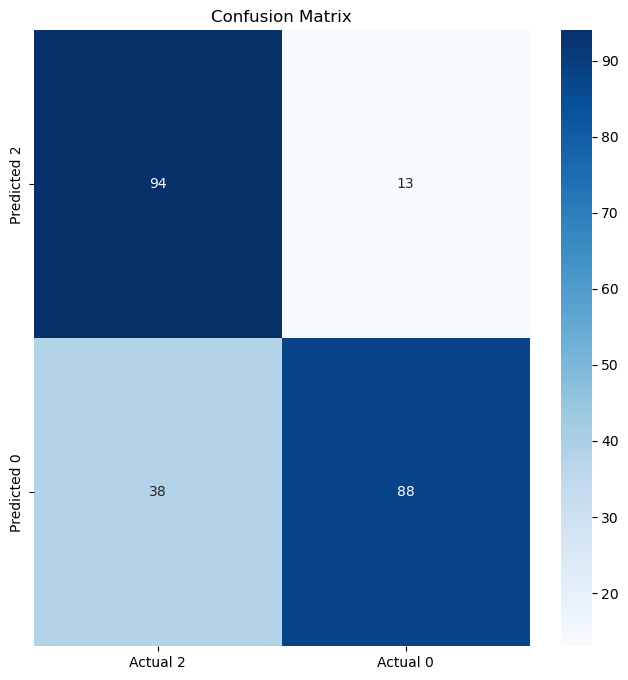

              precision    recall  f1-score   support

         0.0       0.71      0.88      0.79       107
         2.0       0.87      0.70      0.78       126

    accuracy                           0.78       233
   macro avg       0.79      0.79      0.78       233
weighted avg       0.80      0.78      0.78       233

GOOG
68.6695278969957


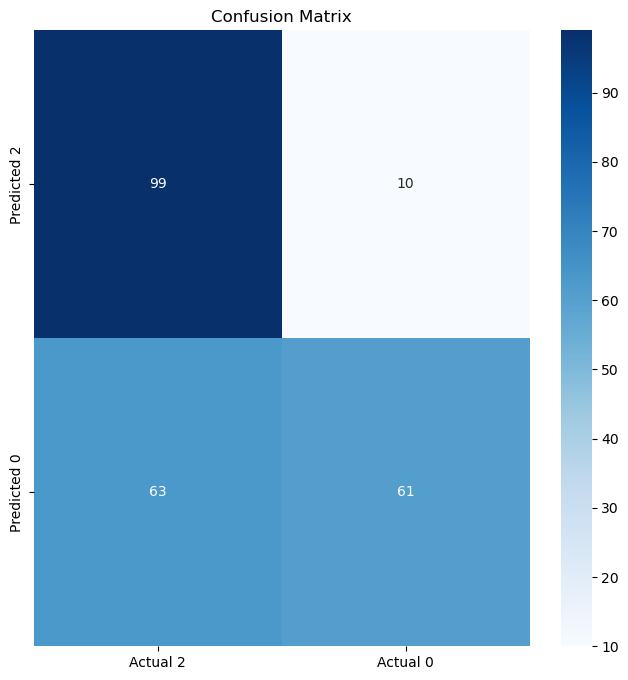

              precision    recall  f1-score   support

         0.0       0.61      0.91      0.73       109
         2.0       0.86      0.49      0.63       124

    accuracy                           0.69       233
   macro avg       0.74      0.70      0.68       233
weighted avg       0.74      0.69      0.67       233

V
72.53218884120172


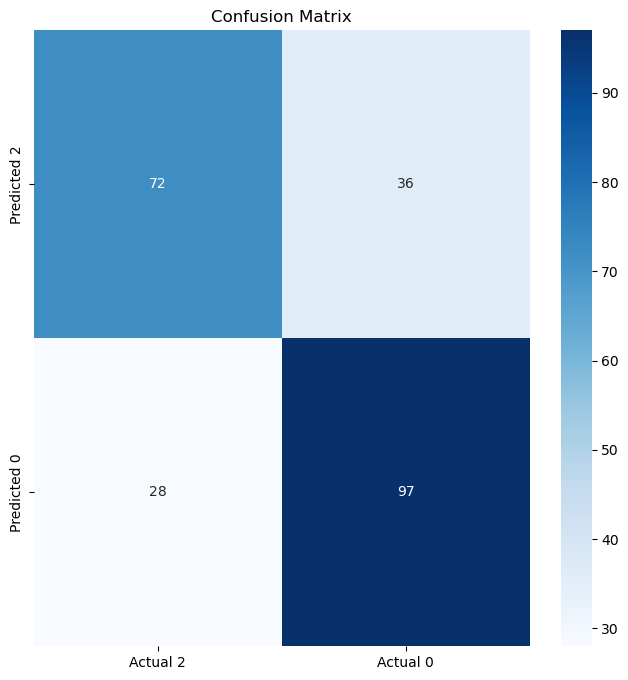

              precision    recall  f1-score   support

         0.0       0.72      0.67      0.69       108
         2.0       0.73      0.78      0.75       125

    accuracy                           0.73       233
   macro avg       0.72      0.72      0.72       233
weighted avg       0.73      0.73      0.72       233



In [112]:
for i in range(len(list_test)):
    
    y_test = list_test[i][TARGET]
    y_pred = list_test[i]['Direction_prediction']
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print(GROUPS[i])
    print(accuracy*100)
    
    plt.figure(figsize=(8, 8))

    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=['Actual 2', 'Actual 0'], 
        yticklabels=['Predicted 2', 'Predicted 0']
    )

    plt.title('Confusion Matrix')
    plt.show()

    print(class_report)
    
    #save results as csv
    filepath = Path(f'./csvDataFrames/ticker_{GROUPS[i]}.csv')  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    list_test[i].to_csv(filepath)
    